# Libraries

### Install

In [1]:
! pip install calmap

### Import

In [2]:
# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from plotnine import *
import calmap

import plotly.express as px
import folium

# color pallette

c = '#393e46'
d = '#ff2e63'
r = '#30e3ca'
i = '#f8b400'
cdr = [c, d, r] # grey - red - blue
idr = [i, d, r] # yellow - red - blue

# Dataset

In [3]:
!ls ../input/corona-virus-report

covid_19_clean_complete.csv


In [4]:
# importing datasets
full_table = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
full_table.head()

Province/State  Country/Region      Lat      Long       Date  Confirmed  \
0          Anhui  Mainland China  31.8257  117.2264 2020-01-22        1.0   
1        Beijing  Mainland China  40.1824  116.4142 2020-01-22       14.0   
2      Chongqing  Mainland China  30.0572  107.8740 2020-01-22        6.0   
3         Fujian  Mainland China  26.0789  117.9874 2020-01-22        1.0   
4          Gansu  Mainland China  36.0611  103.8343 2020-01-22        0.0   

   Deaths  Recovered  
0     0.0        0.0  
1     0.0        0.0  
2     0.0        0.0  
3     0.0        0.0  
4     0.0        0.0

In [5]:
# dataframe info
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9090 entries, 0 to 9089
Data columns (total 8 columns):
Province/State    4995 non-null object
Country/Region    9090 non-null object
Lat               9090 non-null float64
Long              9090 non-null float64
Date              9090 non-null datetime64[ns]
Confirmed         9087 non-null float64
Deaths            9087 non-null float64
Recovered         9087 non-null float64
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 568.2+ KB


In [6]:
# checking for missing value
# full_table.isna().sum()

# Preprocessing

### Cleaning Data

In [7]:
# still infected = confirmed - deaths - recovered
full_table['Still Infected'] = full_table['Confirmed'] - full_table['Deaths'] -full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values with NA
full_table[['Province/State']] = full_table[['Province/State']].fillna('NA')
full_table[['Confirmed', 'Deaths', 'Recovered', 'Still Infected']] = full_table[['Confirmed', 'Deaths', 'Recovered', 'Still Infected']].fillna(0)

### Derived Tables

In [8]:
# complete dataset 
# complete = full_table.copy()

# cases in the Diamond Princess cruise ship
ship = full_table[full_table['Province/State']=='Diamond Princess cruise ship']

# full table
full_table = full_table[full_table['Province/State']!='Diamond Princess cruise ship']
china = full_table[full_table['Country/Region']=='China']
row = full_table[full_table['Country/Region']!='China']

# latest
full_latest = full_table[full_table['Date'] == max(full_table['Date'])].reset_index()
china_latest = full_latest[full_latest['Country/Region']=='China']
row_latest = full_latest[full_latest['Country/Region']!='China']

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum().reset_index()
china_latest_grouped = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum().reset_index()
row_latest_grouped = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum().reset_index()

# Latest Data

### Latest Complete Data

In [9]:
temp = full_table.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 'Still Infected'].max()
temp.style.background_gradient(cmap='Pastel1_r')

### Latest Condensed Data

In [10]:
temp = full_table.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Still Infected'].sum()
temp = temp.reset_index()
temp = temp.sort_values('Date', ascending=False)
temp.head(1).reset_index(drop=True).style.background_gradient(cmap='Pastel1')

In [11]:
tm = temp.head(1).melt(id_vars="Date", value_vars=['Still Infected', 'Deaths', 'Recovered'])
fig = px.treemap(tm, path=["variable"], values="value", height=200, 
                 color_discrete_sequence = [r, i, d])
fig.show()

# Country wise Data

### In each country

In [12]:
temp_f = full_latest_grouped[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
temp_f = temp_f.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f.style.background_gradient(cmap='Pastel1_r')

### Countries with deaths reported

In [13]:
temp_flg = full_latest_grouped[['Country/Region', 'Deaths']]
temp_flg = temp_flg.sort_values(by='Deaths', ascending=False)
temp_flg = temp_flg.reset_index(drop=True)
temp_flg = temp_flg[temp_flg['Deaths']>0]
temp_flg.style.background_gradient(cmap='Reds')

### Countries with no cases recovered

In [14]:
temp = full_latest_grouped[full_latest_grouped['Recovered']==0]
temp = temp[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Reds')

### Countries with all cases died

In [15]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==
                          row_latest_grouped['Deaths']]
temp = temp[['Country/Region', 'Confirmed', 'Deaths']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Reds')

### Countries with all the cases recovered

In [16]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==
                          row_latest_grouped['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

### Countries with no affected case anymore

In [17]:
temp = row_latest_grouped[row_latest_grouped['Confirmed']==
                          row_latest_grouped['Deaths']+
                          row_latest_grouped['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

### Chinese province wise data

### In each provinces

In [18]:
temp_f = china_latest_grouped[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp_f = temp_f.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f.style.background_gradient(cmap='Pastel1_r')

### Provinces with no cases recovered

In [19]:
temp = china_latest_grouped[china_latest_grouped['Recovered']==0]
temp = temp[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Pastel1_r')

### Provinces with all cases died

In [20]:
temp = china_latest_grouped[china_latest_grouped['Confirmed']==
                          china_latest_grouped['Deaths']]
temp = temp[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

### Provinces with all the cases recovered

In [21]:
temp = china_latest_grouped[china_latest_grouped['Confirmed']==
                          china_latest_grouped['Recovered']]
temp = temp[['Province/State', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

### Provinces with no affected case anymore

In [22]:
temp = china_latest_grouped[china_latest_grouped['Confirmed']==
                          china_latest_grouped['Deaths']+
                          china_latest_grouped['Recovered']]
temp = temp[['Province/State', 'Confirmed', 'Deaths', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

# Maps

### Across the globe

In [23]:
# World wide

m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=4, zoom_start=1)

for i in range(0, len(full_latest)):
    folium.Circle(
        location=[full_latest.iloc[i]['Lat'], full_latest.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(full_latest.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(full_latest.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(full_latest.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(full_latest.iloc[i]['Deaths'])+
                    '<li><bold>Recovered : '+str(full_latest.iloc[i]['Recovered']),
        radius=int(full_latest.iloc[i]['Confirmed'])).add_to(m)
m

### Reported cases in China

In [24]:
# China 

m = folium.Map(location=[30, 116], tiles='cartodbpositron',
               min_zoom=2, max_zoom=5, zoom_start=3)

for i in range(0, len(china_latest)):
    folium.Circle(
        location=[china_latest.iloc[i]['Lat'], china_latest.iloc[i]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Country : '+str(china_latest.iloc[i]['Country/Region'])+
                    '<li><bold>Province : '+str(china_latest.iloc[i]['Province/State'])+
                    '<li><bold>Confirmed : '+str(china_latest.iloc[i]['Confirmed'])+
                    '<li><bold>Deaths : '+str(china_latest.iloc[i]['Deaths'])+
                    '<li><bold>Recovered : '+str(china_latest.iloc[i]['Recovered']),
        radius=int(china_latest.iloc[i]['Confirmed'])**1).add_to(m)
m

### Diamond Princess Cruise Ship

In [25]:
# Cases in the Diamond Princess Cruise Ship
temp = ship.sort_values(by='Date', ascending=False).head(1)
temp = temp[['Province/State', 'Confirmed', 'Deaths', 'Recovered']].reset_index(drop=True)
print(temp.style.background_gradient(cmap='rainbow'))

temp = ship[ship['Date'] == max(ship['Date'])].reset_index()

m = folium.Map(location=[35.4437, 139.638], tiles='cartodbpositron',
               min_zoom=8, max_zoom=12, zoom_start=10)

folium.Circle(location=[temp.iloc[0]['Lat'], temp.iloc[0]['Long']],
        color='crimson', 
        tooltip =   '<li><bold>Ship : '+str(temp.iloc[0]['Province/State'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[0]['Confirmed'])+
                    '<li><bold>Deaths : '+str(temp.iloc[0]['Deaths'])+
                    '<li><bold>Recovered : '+str(temp.iloc[0]['Recovered']),
        radius=int(temp.iloc[0]['Confirmed'])**1).add_to(m)
m

* The Diamond Princess cruise ship was carrying 3,711 passengers and crew on board
* Ship arrived in Yokohama, near Tokyo, on February 3
* [https://www.princess.com/news/notices_and_advisories/notices/diamond-princess-update.html](https://www.princess.com/news/notices_and_advisories/notices/diamond-princess-update.html)

### Affected Countries

In [26]:
fig = px.choropleth(full_latest_grouped, locations="Country/Region", 
                    locationmode='country names', color="Confirmed", 
                    hover_name="Country/Region", range_color=[1,2000], 
                    color_continuous_scale="aggrnyl", 
                    title='Countries with Confirmed Cases')
fig.update(layout_coloraxis_showscale=False)
fig.show()

# ------------------------------------------------------------------------

fig = px.choropleth(full_latest_grouped[full_latest_grouped['Deaths']>0], 
                    locations="Country/Region", locationmode='country names',
                    color="Deaths", hover_name="Country/Region", 
                    range_color=[1,50], color_continuous_scale="agsunset",
                    title='Countries with Deaths Reported')
fig.update(layout_coloraxis_showscale=False)
fig.show()

### Spread over the time

In [27]:
formated_gdf = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf = formated_gdf[formated_gdf['Country/Region']!='China']
formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['size'] = formated_gdf['Confirmed'].pow(0.5)

fig = px.scatter_geo(formated_gdf[formated_gdf['Country/Region']!='China'], 
                     locations="Country/Region", locationmode='country names', 
                     color="Confirmed", size='size', hover_name="Country/Region", 
                     range_color= [0, max(formated_gdf['Confirmed'])+2], 
                     projection="natural earth", animation_frame="Date", 
                     title='Spread outside China over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

# -----------------------------------------------------------------------------------

china_map = china.groupby(['Date', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 
                                                      'Lat', 'Long'].max()
china_map = china_map.reset_index()
china_map['size'] = china_map['Confirmed'].pow(0.5)
china_map['Date'] = pd.to_datetime(china_map['Date'])
china_map['Date'] = china_map['Date'].dt.strftime('%m/%d/%Y')
china_map.head()

fig = px.scatter_geo(china_map, lat='Lat', lon='Long', scope='asia',
                     color="size", size='size', hover_name='Province/State', 
                     hover_data=['Confirmed', 'Deaths', 'Recovered'],
                     projection="natural earth", animation_frame="Date", 
                     title='Spread in China over time')
fig.update(layout_coloraxis_showscale=False)
fig.show()

# No. cases in each countries

In [28]:
fig = px.bar(full_latest_grouped[['Country/Region', 'Confirmed']].sort_values('Confirmed', ascending=False), 
             y="Confirmed", x="Country/Region", color='Country/Region', 
             log_y=True, template='ggplot2', title='Confirmed Cases')
fig.show()

fig = px.bar(full_latest_grouped[['Country/Region', 'Deaths']].sort_values('Deaths', ascending=False), 
             y="Deaths", x="Country/Region", color='Country/Region', title='Deaths',
             log_y=True, template='ggplot2')
fig.show()

# No. of cases each day

In [29]:
temp = full_table.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()
temp = temp.reset_index()
# temp.head()

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region', orientation='v', height=600,
             title='Confirmed', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.show()

fig = px.bar(temp, x="Date", y="Deaths", color='Country/Region', orientation='v', height=600,
             title='Deaths', color_discrete_sequence = px.colors.cyclical.mygbm)
fig.show()

# No. of new cases everyday

In [30]:
# In China
temp = china.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().diff()
temp = temp.reset_index()
temp = temp.melt(id_vars="Date", 
                 value_vars=['Confirmed', 'Deaths', 'Recovered'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             title='In China',
             color_discrete_sequence=cdr)
fig.update_layout(barmode='group')
fig.show()

#-----------------------------------------------------------------------------

# ROW
temp = row.groupby('Date')['Confirmed', 'Deaths', 'Recovered'].sum().diff()
temp = temp.reset_index()
temp = temp.melt(id_vars="Date", 
                 value_vars=['Confirmed', 'Deaths', 'Recovered'])

fig = px.bar(temp, x="Date", y="value", color='variable', 
             title='Outside China',
             color_discrete_sequence=cdr)
fig.update_layout(barmode='group')
fig.show()

In [31]:
def from_china_or_not(row):
    if row['Country/Region']=='China':
        return 'From China'
    else:
        return 'Outside China'
    
temp = full_table.copy()
temp['Region'] = temp.apply(from_china_or_not, axis=1)
temp = temp.groupby(['Region', 'Date'])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Region'] != temp['Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

fig = px.bar(temp, x='Date', y='Confirmed', color='Region', barmode='group', 
             text='Confirmed', title='Confirmed', color_discrete_sequence= cdr)
fig.update_traces(textposition='outside')
fig.show()

fig = px.bar(temp, x='Date', y='Deaths', color='Region', barmode='group', 
             text='Confirmed', title='Deaths', color_discrete_sequence= cdr)
fig.update_traces(textposition='outside')
fig.update_traces(textangle=-90)
fig.show()

In [32]:
temp = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

fig = px.bar(temp, x="Date", y="Confirmed", color='Country/Region',
             title='Number of new cases everyday')
fig.show()

fig = px.bar(temp[temp['Country/Region']!='China'], x="Date", y="Confirmed", color='Country/Region',
             title='Number of new cases outside China everyday')
fig.show()

fig = px.bar(temp, x="Date", y="Deaths", color='Country/Region',
             title='Number of new death case reported outside China everyday')
fig.show()

fig = px.bar(temp[temp['Country/Region']!='China'], x="Date", y="Deaths", color='Country/Region',
             title='Number of new death case reported outside China everyday')
fig.show()

# No. of places to which COVID-19 spread

In [33]:
c_spread = china[china['Confirmed']!=0].groupby('Date')['Province/State'].unique().apply(len)
c_spread = pd.DataFrame(c_spread).reset_index()

fig = px.line(c_spread, x='Date', y='Province/State', 
              title='Number of Provinces/States/Regions of China to which COVID-19 spread over the time',
             color_discrete_sequence=cdr)
fig.show()

# ------------------------------------------------------------------------------------------

spread = full_table[full_table['Confirmed']!=0].groupby('Date')['Country/Region'].unique().apply(len)
spread = pd.DataFrame(spread).reset_index()

fig = px.line(spread, x='Date', y='Country/Region', 
              title='Number of Countries/Regions to which COVID-19 spread over the time',
             color_discrete_sequence=cdr)
fig.show()

# China vs ROW

In [34]:
gdf = gdf = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
gdf = gdf.reset_index()

temp = gdf[gdf['Country/Region']=='China'].reset_index()
temp = temp.melt(id_vars='Date', value_vars=['Confirmed', 'Deaths', 'Recovered'],
                var_name='Case', value_name='Count')
fig = px.bar(temp, x="Date", y="Count", color='Case', facet_col="Case",
            title='Cases in China', color_discrete_sequence=cdr)
fig.show()

temp = gdf[gdf['Country/Region']!='China'].groupby('Date').sum().reset_index()
temp = temp.melt(id_vars='Date', value_vars=['Confirmed', 'Deaths', 'Recovered'],
                var_name='Case', value_name='Count')
fig = px.bar(temp, x="Date", y="Count", color='Case', facet_col="Case",
             title='Cases Outside China', color_discrete_sequence=cdr)
fig.show()

# Hubei - China - World

In [35]:
def location(row):
    if row['Country/Region']=='China':
        if row['Province/State']=='Hubei':
            return 'Hubei'
        else:
            return 'Other Chinese Provinces'
    else:
        return 'Rest of the World'

temp = full_table.copy()
temp['Region'] = temp.apply(location, axis=1)
temp['Date'] = temp['Date'].dt.strftime('%Y-%m-%d')
temp = temp.groupby(['Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
temp = temp.melt(id_vars=['Region', 'Date'], value_vars=['Confirmed', 'Deaths', 'Recovered'], 
                 var_name='Case', value_name='Count').sort_values('Count')
# temp = temp.sort_values(['Date', 'Region', 'Case']).reset_index()
temp.head()

fig = px.bar(temp, y='Region', x='Count', color='Case', barmode='group', orientation='h',
             text='Count', title='Hubei - China - World', animation_frame='Date',
             color_discrete_sequence= [d, r, c], range_x=[0, 70000])
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_layout(yaxis={'categoryorder':'array', 
                         'categoryarray':['Hubei','Other Chinese Provinces','Rest of the World']})
fig.show()

temp = full_latest.copy()
temp['Region'] = temp.apply(location, axis=1)
temp = temp.groupby('Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
temp = temp.melt(id_vars='Region', value_vars=['Confirmed', 'Deaths', 'Recovered'], 
                 var_name='Case', value_name='Count').sort_values('Count')
temp.head()

fig = px.bar(temp, y='Region', x='Count', color='Case', barmode='group', orientation='h',
             text='Count', title='Hubei - China - World', 
             color_discrete_sequence= [d, r, c])
fig.update_traces(textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

# Recovery and Mortality Rate Over The Time

In [36]:
temp = full_table.groupby('Date').sum().reset_index()
temp.head()

# adding two more columns
temp['No. of Deaths to 100 Confirmed Cases'] = round(temp['Deaths']/
                                                     temp['Confirmed'], 3)*100
temp['No. of Recovered to 100 Confirmed Cases'] = round(temp['Recovered']/
                                                        temp['Confirmed'], 3)*100
temp['No. of Recovered to 1 Death Case'] = round(temp['Recovered']/
                                                 temp['Deaths'], 3)

temp = temp.melt(id_vars='Date', 
                 value_vars=['No. of Deaths to 100 Confirmed Cases', 
                             'No. of Recovered to 100 Confirmed Cases', 
                             'No. of Recovered to 1 Death Case'], 
                 var_name='Ratio', 
                 value_name='Value')

fig = px.line(temp, x="Date", y="Value", color='Ratio', 
              title='Recovery and Mortality Rate Over The Time',color_discrete_sequence=cdr)
fig.show()

# Proportion of Cases

In [37]:
rl = row_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum()
rl = rl.reset_index().sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
rl.head().style.background_gradient(cmap='rainbow')

ncl = rl.copy()
ncl['Affected'] = ncl['Confirmed'] - ncl['Deaths'] - ncl['Recovered']
ncl = ncl.melt(id_vars="Country/Region", value_vars=['Affected', 'Recovered', 'Deaths'])

fig = px.bar(ncl.sort_values(['variable', 'value']), 
             x="Country/Region", y="value", color='variable', orientation='v', height=800,
             # height=600, width=1000,
             title='Number of Cases outside China', color_discrete_sequence=cdr)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

# ------------------------------------------

cl = china_latest.groupby('Province/State')['Confirmed', 'Deaths', 'Recovered'].sum()
cl = cl.reset_index().sort_values(by='Confirmed', ascending=False).reset_index(drop=True)
# cl.head().style.background_gradient(cmap='rainbow')

ncl = cl.copy()
ncl['Affected'] = ncl['Confirmed'] - ncl['Deaths'] - ncl['Recovered']
ncl = ncl.melt(id_vars="Province/State", value_vars=['Affected', 'Recovered', 'Deaths'])

fig = px.bar(ncl.sort_values(['variable', 'value']), 
             y="Province/State", x="value", color='variable', orientation='h', height=800,
             # height=600, width=1000,
             title='Number of Cases in China', color_discrete_sequence=cdr)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

# Composition of Cases

In [38]:
fig = px.treemap(china_latest.sort_values(by='Confirmed', ascending=False).reset_index(drop=True), 
                 path=["Province/State"], values="Confirmed",
                 title='Number of Confirmed Cases in Chinese Provinces',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.show()

fig = px.treemap(china_latest.sort_values(by='Deaths', ascending=False).reset_index(drop=True), 
                 path=["Province/State"], values="Deaths", 
                 title='Number of Deaths Reported in Chinese Provinces',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.show()

fig = px.treemap(china_latest.sort_values(by='Recovered', ascending=False).reset_index(drop=True), 
                 path=["Province/State"], values="Recovered", 
                 title='Number of Recovered Cases in Chinese Provinces',
                 color_discrete_sequence = px.colors.qualitative.Prism)
fig.show()

# ----------------------------------------------------------------------------

fig = px.treemap(row_latest, path=["Country/Region"], values="Confirmed", 
                 title='Number of Confirmed Cases outside china',
                 color_discrete_sequence = px.colors.qualitative.Pastel)
fig.show()

fig = px.treemap(row_latest, path=["Country/Region"], values="Deaths", 
                 title='Number of Deaths outside china',
                 color_discrete_sequence = px.colors.qualitative.Pastel)
fig.show()

fig = px.treemap(row_latest, path=["Country/Region"], values="Recovered", 
                 title='Number of Recovered Cases outside china',
                 color_discrete_sequence = px.colors.qualitative.Pastel)
fig.show()

# Confirmed cases in each Countries

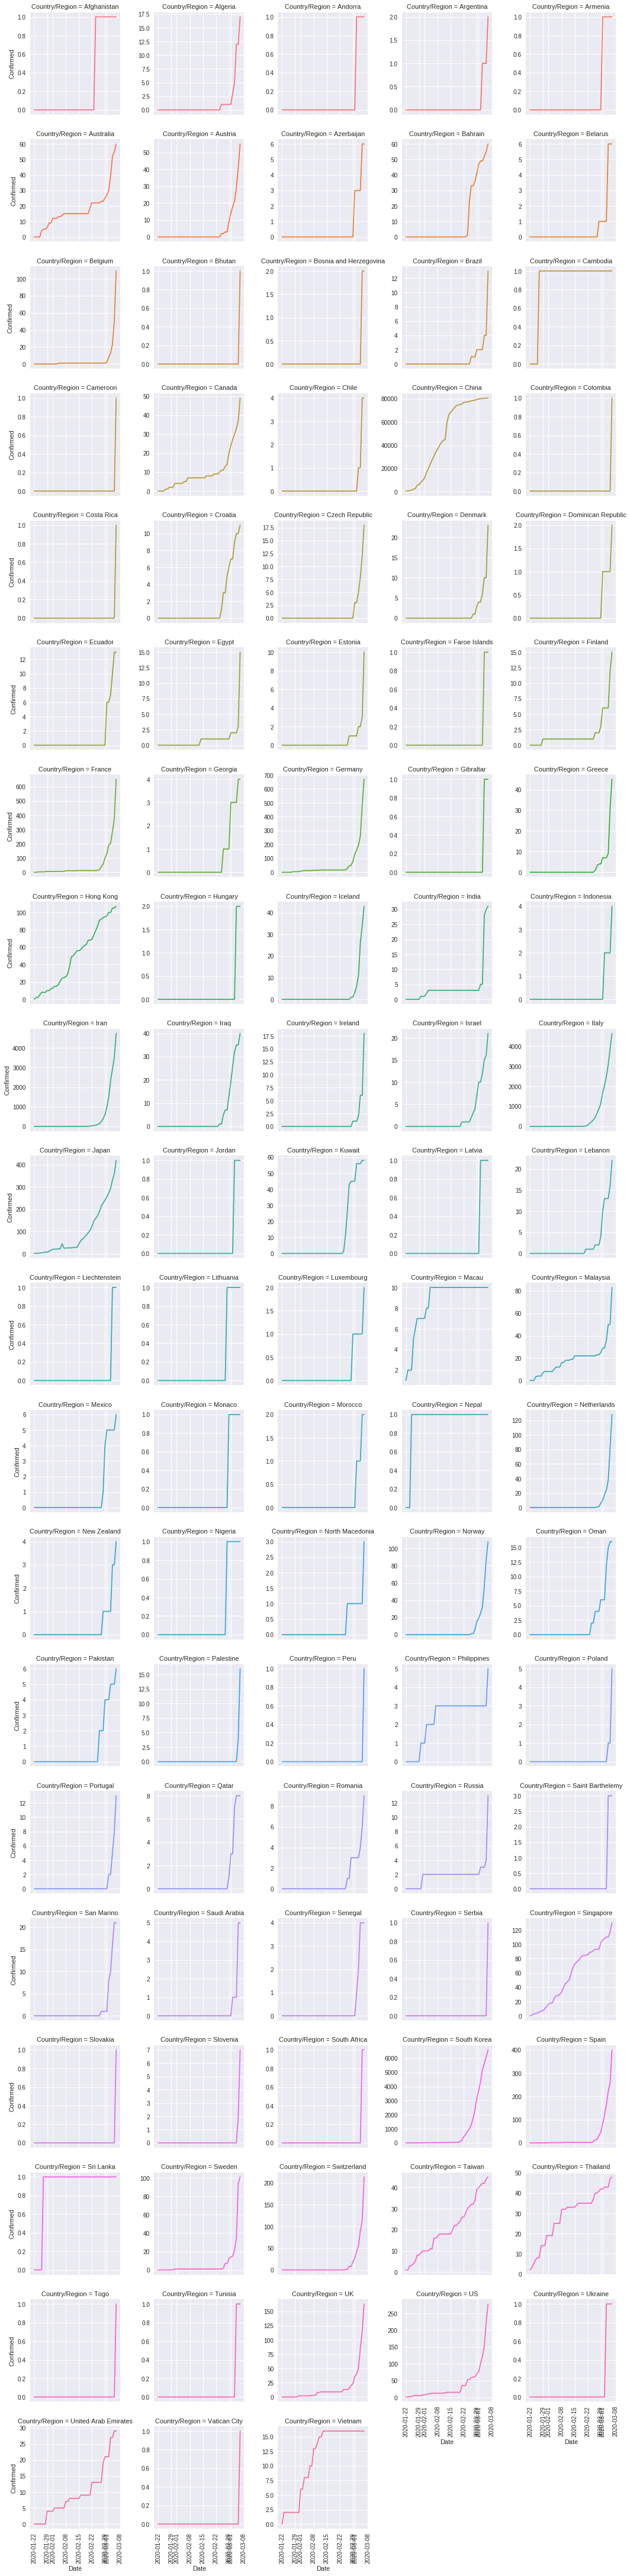

In [39]:
temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum()
temp = temp.reset_index().sort_values(by=['Date', 'Country/Region'])
temp.head()

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col="Country/Region", hue="Country/Region", 
                  sharey=False, col_wrap=5)
g = g.map(plt.plot, "Date", "Confirmed")
g.set_xticklabels(rotation=90)
plt.show()

# New cases in each Countries

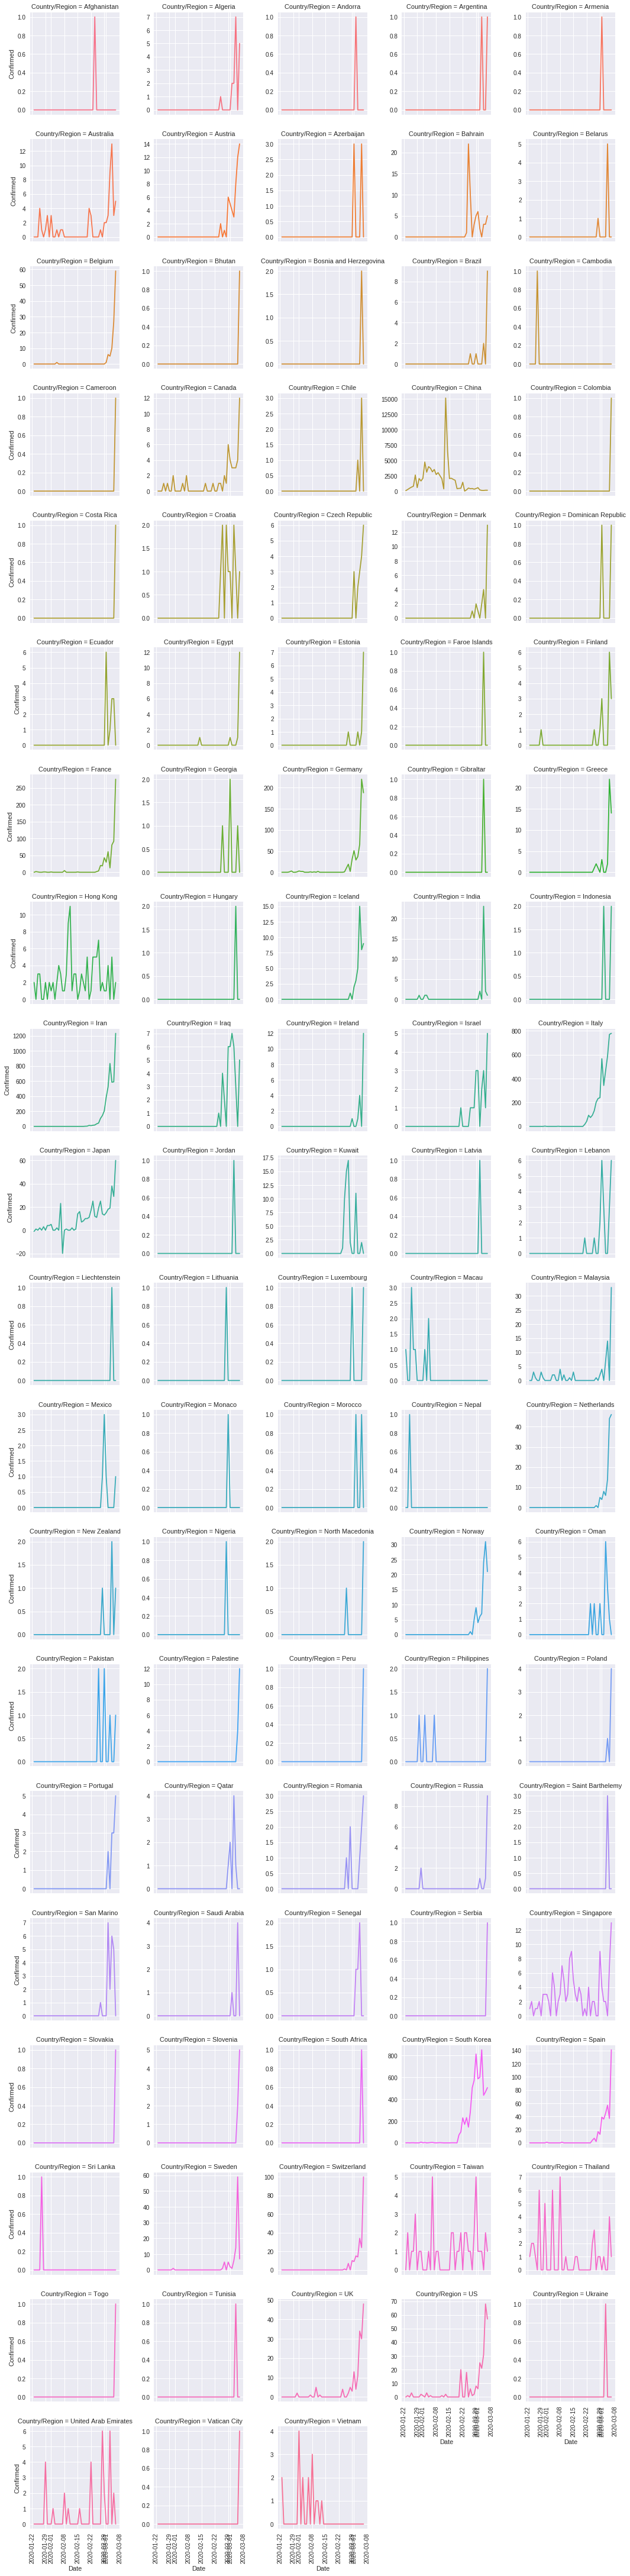

In [40]:
temp = full_table.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

plt.style.use('seaborn')
g = sns.FacetGrid(temp, col="Country/Region", hue="Country/Region", 
                  sharey=False, col_wrap=5)
g = g.map(sns.lineplot, "Date", "Confirmed")
g.set_xticklabels(rotation=90)
plt.show()

# Calander map

### Number of new cases every day

/opt/conda/lib/python3.6/site-packages/calmap/__init__.py:221: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated



[]

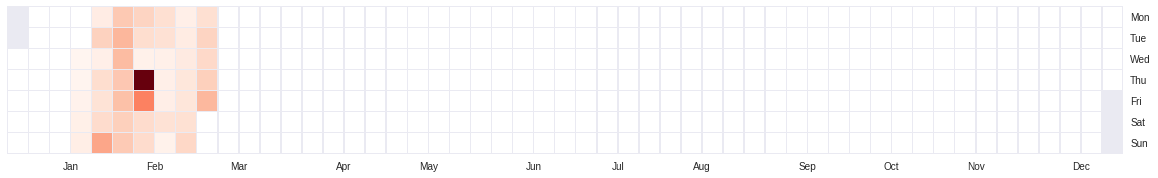

In [41]:
temp = full_table.groupby('Date')['Confirmed'].sum()
temp = temp.diff()

plt.figure(figsize=(20, 5))
calmap.yearplot(temp, fillcolor='white', cmap='Reds', linewidth=0.5)
plt.plot()

### Number of new countries every day

[]

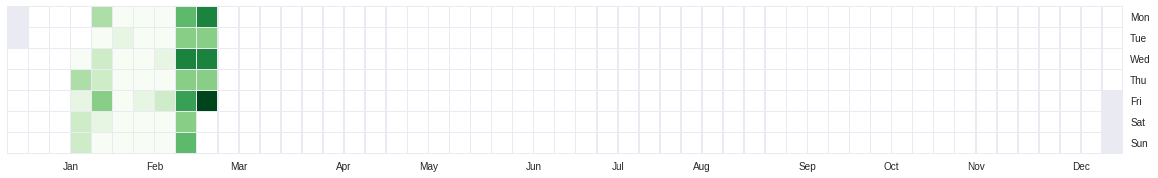

In [42]:
spread = full_table[full_table['Confirmed']!=0].groupby('Date')
spread = spread['Country/Region'].unique().apply(len).diff()

plt.figure(figsize=(20, 5))
calmap.yearplot(spread, fillcolor='white', cmap='Greens', linewidth=0.5)
plt.plot()

# Prediction

# [COVID19 vs SARS vs MERS vs EBOLA vs H1N1](https://www.kaggle.com/imdevskp/covid19-vs-sars-vs-mers-vs-ebola-vs-h1n1)

**For comparison with past epidemics Please see** : https://www.kaggle.com/imdevskp/covid19-vs-sars-vs-mers-vs-ebola-vs-h1n1